In this notebook, the possibility of utilizing the distance of an individuals activity levels to the averaged activity levels of the depressed cohort are explored.

In [63]:
import pandas as pd
import numpy as np

In [64]:
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)

603


In [65]:
#new
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1


Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
16
587


In [13]:
#different iteration method

# list of matrices with different lenght of observed days | row = time-point, col = variable (ith h of day)
d_data_list = []

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]

    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    n_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, n_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    d_data_list.append(matrix)

# get avg d cohort circadian rhythm
avg_d_rhythm = []
tmp_d_rhythm = []

for c in range(24):
    tmp = 0
    for u in d_data_list:
        for r in range(len(u)):
            tmp = tmp + u[r, c]
    tmp_d_rhythm.append(tmp)


for c in tmp_d_rhythm:
    avg_d_rhythm.append(c/len(d_data_list))

#print(avg_d_rhythm)

d_distance_list = []
d_rhythm_list = []
for u in d_data_list:
    avg_u_rhythm = [] #avg does not make sense but hey... nvm
    for c in range(24):
        tmp = 0
        for r in range(len(u)):
            tmp = tmp + u[r, c]
        avg_u_rhythm.append(tmp)

    tmp_list = list(np.array(avg_d_rhythm)-np.array(avg_u_rhythm))

    d_distance_list.append(tmp_list)
    d_rhythm_list.append(avg_u_rhythm)

#do the same for r cohort
r_data_list = []

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]

    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    n_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, n_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    r_data_list.append(matrix)


avg_r_rhythm = []
tmp_r_rhythm = []

for c in range(24):
    tmp = 0
    for u in r_data_list:
        for r in range(len(u)):
            tmp = tmp + u[r, c]
    tmp_r_rhythm.append(tmp)


for c in tmp_r_rhythm:
    avg_r_rhythm.append(c/len(r_data_list))

r_distance_list = []
r_rhythm_list = []
for u in r_data_list:
    avg_u_rhythm = []
    for c in range(24):
        tmp = 0
        for r in range(len(u)):
            tmp = tmp + u[r, c]
        avg_u_rhythm.append(tmp)

    tmp_list = list(np.array(avg_d_rhythm)-np.array(avg_u_rhythm))

    r_distance_list.append(tmp_list)
    r_rhythm_list.append(avg_u_rhythm)


In [14]:
print(d_distance_list)
print(r_distance_list)

[[4.975124378109452, 12.401326699834161, 7.752902155887231, 9.45771144278607, 1.6948590381426207, -10.159203980099502, 3.7197346600331667, 4.313432835820896, 3.9817578772802653, 3.0713101160862353, 6.8988391376451075, 6.354892205638475, 10.288557213930348, 11.676616915422885, 8.734660033167495, -0.7412935323383092, 7.2487562189054735, -1.9087893864013274, -1.8308457711442792, 2.9535655058043133, -3.160862354892206, 4.958540630182423, 4.777777777777779, 4.2106135986733015], [-2.0248756218905477, 9.401326699834161, 6.752902155887231, -4.542288557213929, -12.30514096185738, -19.1592039800995, -7.280265339966833, -1.6865671641791042, 3.9817578772802653, -0.9286898839137647, 7.8988391376451075, 9.354892205638475, 7.288557213930348, 6.676616915422885, -7.265339966832505, 8.25870646766169, 12.248756218905474, 13.091210613598673, 7.169154228855721, 16.953565505804313, -0.16086235489220613, -5.041459369817577, 6.777777777777779, 11.210613598673302], [-10.024875621890548, -2.5986733001658386, -0

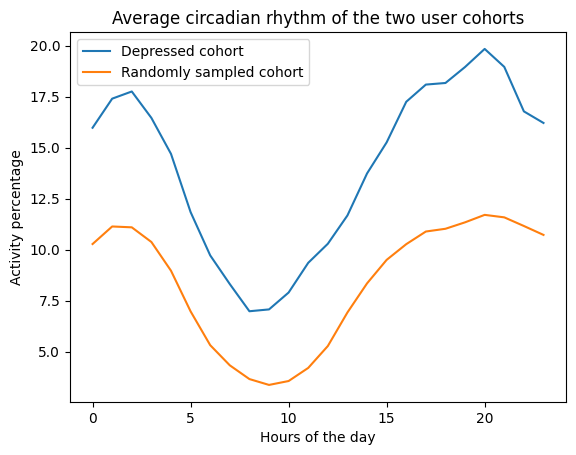

In [15]:
import matplotlib.pyplot as plt
plt.plot(avg_d_rhythm)
plt.plot(avg_r_rhythm)
plt.xlabel('Hours of the day')
plt.ylabel('Activity percentage')
plt.legend(['Depressed cohort', 'Randomly sampled cohort'])
plt.title('Average circadian rhythm of the two user cohorts')
plt.show()

In [16]:
# d cohort rhythm avg sum
d_avg_sum = sum(avg_d_rhythm)

#for individual users
d_distance_sum_list = []
for u in d_distance_list:
    d_distance_sum_list.append(sum(u))

r_distance_sum_list = []
for u in r_distance_list:
    r_distance_sum_list.append(sum(u))

d_sum_list = []
for u in d_rhythm_list:
    d_sum_list.append(sum(u))

r_sum_list = []
for u in r_rhythm_list:
    r_sum_list.append(sum(u))

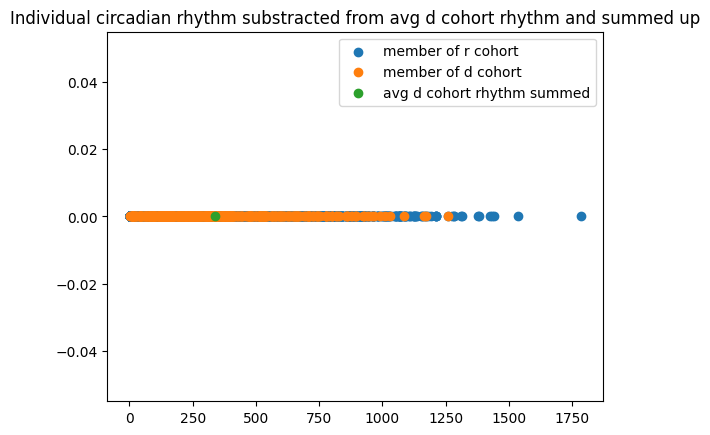

In [19]:

plt.scatter(r_sum_list, np.full_like(r_sum_list,0.1))
plt.scatter(d_sum_list, np.full_like(d_sum_list,-0.1))
plt.scatter(d_avg_sum, 0)
plt.legend(['member of r cohort', 'member of d cohort', 'avg d cohort rhythm summed'])
plt.title('Individual circadian rhythm substracted from avg d cohort rhythm and summed up')
plt.show()

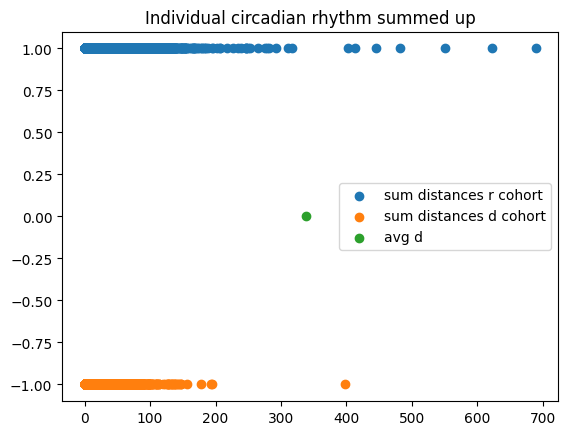

In [26]:
plt.scatter(r_rhythm_list, np.full_like(r_rhythm_list, 1))
plt.scatter(d_rhythm_list, np.full_like(d_rhythm_list, -1))
plt.scatter(d_avg_sum, 0)
plt.legend(['sum distances r cohort', 'sum distances d cohort', 'avg d'])
plt.title('Individual circadian rhythm summed up')
plt.show()

In [66]:
#different division method

# list of matrices with different lenght of observed days | row = time-point, col = variable (ith h of day)
d_data_list = []

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]

    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    n_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, n_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    d_data_list.append(matrix)

#do the same for r cohort
r_data_list = []

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]

    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    n_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, n_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    r_data_list.append(matrix)


In [67]:
# create d cohort time matrix (#users-in-d-cohortx24)
d_dayhourmatrix = np.full((len(d_data_list), 24), 0, dtype=float)
for j in range(len(d_data_list)):
    u = d_data_list[j]
    tmp_total_tweets = float(u.sum())
    for c in range(24):
        tmp = 0.0
        for r in range(len(u)):
            tmp = tmp + u[r, c]
        res = (tmp/tmp_total_tweets)  #see notes from 09.11.
        d_dayhourmatrix[j,c] = res

avg_d_rhythm = []
for c in range(24):
    tmp = 0.0
    for r in range(len(d_dayhourmatrix)):
        tmp = tmp + d_dayhourmatrix[r,c]
    avg_d_rhythm.append(tmp/float(len(d_dayhourmatrix)))

In [68]:
r_dayhourmatrix = np.full((len(r_data_list), 24), 0, dtype=float)
for j in range(len(r_data_list)):
    u = r_data_list[j]
    tmp_total_tweets = float(u.sum())
    for c in range(24):
        tmp = 0.0
        for r in range(len(u)):
            tmp = tmp + u[r, c]
        res = (tmp/tmp_total_tweets)
        r_dayhourmatrix[j,c] = res #see notes from 09.11.

avg_r_rhythm = []
for c in range(24):
    tmp = 0.0
    for r in range(len(r_dayhourmatrix)):
        tmp = tmp + r_dayhourmatrix[r,c]
    avg_r_rhythm.append(tmp/float(len(r_dayhourmatrix)))

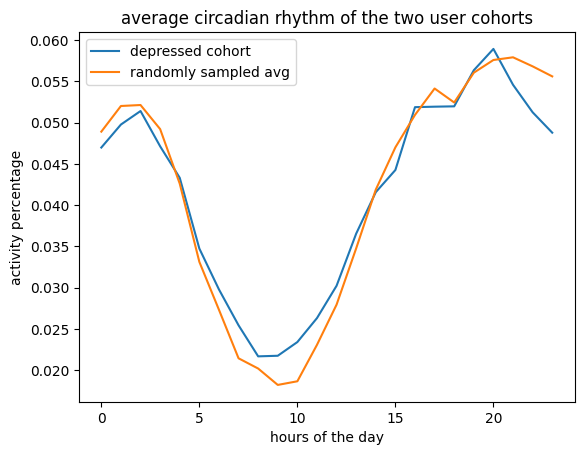

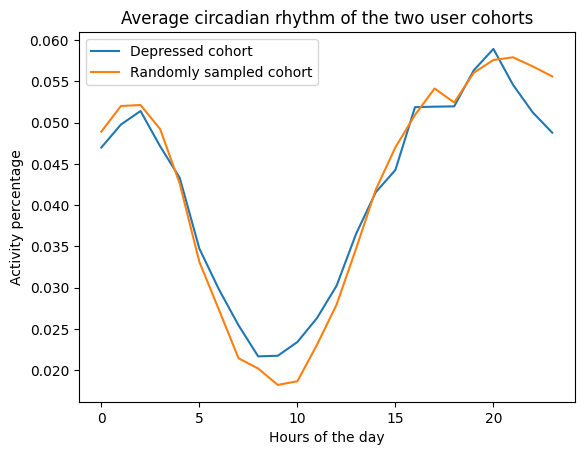

In [9]:
import matplotlib.pyplot as plt
plt.plot(avg_d_rhythm)
plt.plot(avg_r_rhythm)
plt.xlabel('Hours of the day')
plt.ylabel('Activity percentage')
plt.legend(['Depressed cohort', 'Randomly sampled cohort'])
plt.title('Average circadian rhythm of the two user cohorts')
plt.show()

In [69]:
d_sum_list = []
d_dif_sum_list = []
d_avg_sum = sum(avg_d_rhythm)
for u in range(len(d_dayhourmatrix)):
    d_sum_list.append(sum(d_dayhourmatrix[u,:]))
    d_dif_sum_list.append(d_avg_sum-sum(d_dayhourmatrix[u,:]))

r_sum_list = []
r_dif_sum_list = []
r_avg_sum = sum(avg_r_rhythm)
for u in range(len(r_dayhourmatrix)):
    r_sum_list.append(sum(r_dayhourmatrix[u,:]))
    r_dif_sum_list.append(r_avg_sum-sum(r_dayhourmatrix[u,:]))

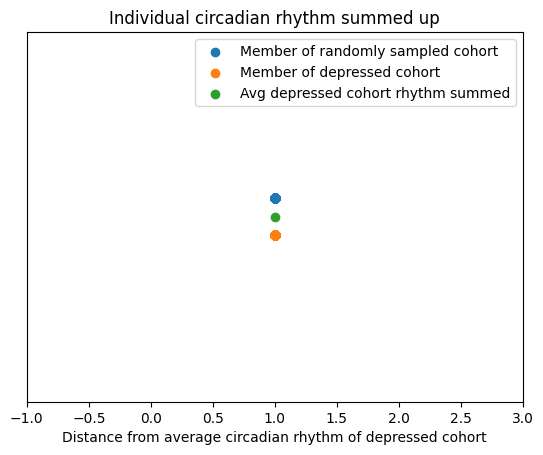

In [174]:
plt.scatter(r_sum_list, np.full_like(r_sum_list,0.1))
plt.scatter(d_sum_list, np.full_like(d_sum_list,-0.1))
plt.scatter(d_avg_sum, 0)
plt.xlabel('Distance from average circadian rhythm of depressed cohort')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)
ax.set_ylim([-1, 1])
ax.set_xlim([-1, 3])
plt.legend(['Member of randomly sampled cohort', 'Member of depressed cohort', 'Avg depressed cohort rhythm summed'])
plt.title('Individual circadian rhythm summed up')
plt.show()

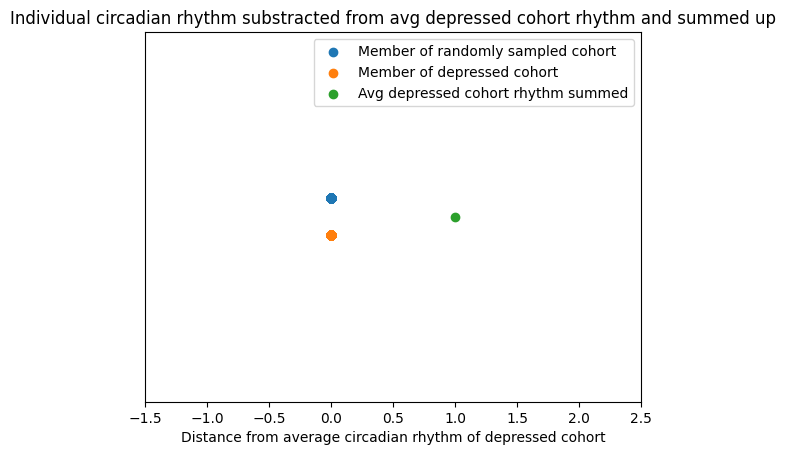

In [175]:
import matplotlib.pyplot as plt
plt.scatter(r_dif_sum_list, np.full_like(r_dif_sum_list,0.1))
plt.scatter(d_dif_sum_list, np.full_like(d_dif_sum_list,-0.1))
plt.scatter(d_avg_sum, 0)
plt.xlabel('Distance from average circadian rhythm of depressed cohort')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.set_ylim([-1, 1])
ax.set_xlim([-1.5, 2.5])
plt.legend(['Member of randomly sampled cohort', 'Member of depressed cohort', 'Avg depressed cohort rhythm summed'])
plt.title('Individual circadian rhythm substracted from avg depressed cohort rhythm and summed up')
plt.show()

[]

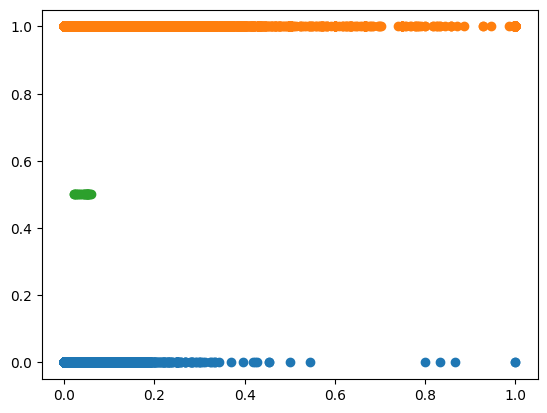

In [87]:
plt.scatter(d_dayhourmatrix, np.full_like(d_dayhourmatrix, 0))
plt.scatter(r_dayhourmatrix, np.full_like(r_dayhourmatrix, 1))
plt.scatter(avg_d_rhythm, np.full_like(avg_d_rhythm, 0.5))
plt.plot()

In [181]:
import numpy as np
d_difference_list = []
for u in range(len(d_dayhourmatrix)):
    d_difference_list.append(np.subtract(avg_d_rhythm,d_dayhourmatrix[u,:]))
    d_diff_matrix = np.array(d_difference_list)

In [184]:
avg_d_distance = []
for c in range(24):
    tmp = 0.0
    for r in range(len(d_diff_matrix)):
        tmp = tmp + d_diff_matrix[r,c]
    avg_d_distance.append(tmp/float(len(d_diff_matrix)))

In [185]:
r_difference_list = []
for u in range(len(r_dayhourmatrix)):
    r_difference_list.append(np.subtract(avg_d_rhythm,r_dayhourmatrix[u,:]))
r_diff_matrix = np.array(r_difference_list)

In [186]:
avg_r_distance = []
for c in range(24):
    tmp = 0.0
    for r in range(len(r_diff_matrix)):
        tmp = tmp + r_diff_matrix[r,c]
    avg_r_distance.append(tmp/float(len(r_diff_matrix)))

In [188]:
sum(avg_r_distance)

-4.952635523913784e-16

In [189]:
sum(avg_d_distance)

1.5059010791622215e-16

In [190]:
sum(avg_d_distance)>sum(avg_r_distance)

True

In [191]:
d_diff_avg_list = []
for j in range(len(d_difference_list)):
    d_diff_avg_list.append(sum(d_difference_list[j]/len(d_difference_list[j])))

In [192]:
#d_diff_avg_list

In [193]:
r_diff_avg_list = []
for j in range(len(r_difference_list)):
    r_diff_avg_list.append(sum(r_difference_list[j] / len(r_difference_list[j])))
#r_diff_avg_list

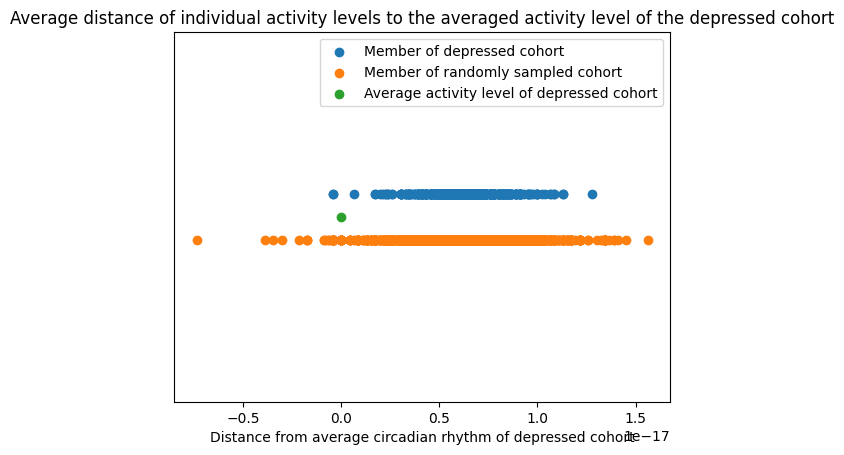

In [196]:
plt.scatter(d_diff_avg_list, np.full_like(d_diff_avg_list,0.25))
plt.scatter(r_diff_avg_list, np.full_like(r_diff_avg_list,-0.25))
plt.scatter(0,0)
ax = plt.gca()
ax.set_ylim([-2, 2])
ax.get_yaxis().set_visible(False)
plt.xlabel('Distance from average activity level of depressed cohort')
plt.legend(['Member of depressed cohort', 'Member of randomly sampled cohort', 'Average activity level of depressed cohort'])
plt.title('Average distance of individual activity levels to the averaged activity level of the depressed cohort')
plt.show()